# Load data and prepare features

## Load Crime data

In [0]:

from pyspark.sql import functions as F
from pyspark.sql.functions import col

# Load crime data from Silver layer
crime_df = spark.read.parquet("dbfs:/FileStore/project/silver/crime_numbeo")
# Check the data
print("=== Crime Data Sample ===")
display(crime_df.limit(5))
# Pivot crime data
crime_pivot = crime_df.groupBy("city").pivot("metric").agg(F.first("score"))

# Clean column names 
for old_col in crime_pivot.columns:
    if old_col != "city":
        new_col = "crime_" + old_col.lower().replace(" ", "_").replace("-", "_")
        crime_pivot = crime_pivot.withColumnRenamed(old_col, new_col)

display(crime_pivot)

=== Crime Data Sample ===


country,metric,score,level,source,last_update,city
United Arab Emirates,Level of crime,12.24,Very Low,Numbeo,2026-01-16,Dubai
United Arab Emirates,Crime increasing in the past 5 years,42.02,Moderate,Numbeo,2026-01-16,Dubai
United Arab Emirates,Worries home broken and things stolen,13.89,Very Low,Numbeo,2026-01-16,Dubai
United Arab Emirates,Worries being mugged or robbed,12.65,Very Low,Numbeo,2026-01-16,Dubai
United Arab Emirates,Worries car stolen,10.26,Very Low,Numbeo,2026-01-16,Dubai


city,crime_crime_increasing_in_the_past_5_years,crime_level_of_crime,crime_problem_corruption_and_bribery,crime_problem_people_using_or_dealing_drugs,crime_problem_property_crimes,crime_problem_violent_crimes,crime_safety_walking_alone_daylight,crime_safety_walking_alone_night,crime_worries_attacked,crime_worries_being_insulted,crime_worries_being_mugged_or_robbed,crime_worries_car_stolen,crime_worries_home_broken_and_things_stolen,crime_worries_physical_attack_due_to_discrimination,crime_worries_things_from_car_stolen
London,78.18,58.77,45.29,76.33,64.17,50.06,66.05,37.51,45.7,51.78,44.65,43.03,49.96,33.67,59.68
Haifa,56.59,24.69,40.54,31.85,33.46,21.72,86.68,69.01,24.34,30.14,17.12,23.68,28.68,23.29,30.42
Tokyo,46.88,21.08,30.35,24.56,23.56,21.37,78.99,73.14,23.19,27.23,20.68,18.44,20.91,25.72,19.59
Tel Aviv,52.54,22.77,43.7,28.17,30.73,18.17,86.71,74.95,21.52,26.88,16.68,22.25,26.35,19.07,27.85
Amsterdam,51.53,31.75,19.88,43.17,37.85,27.59,81.25,64.04,25.52,29.69,26.81,21.66,26.96,21.46,32.6
Rome,66.28,50.7,65.91,53.41,56.67,38.09,75.34,48.08,38.68,39.36,43.3,44.25,47.12,27.45,53.21
Bangkok,56.37,38.0,78.51,50.96,40.49,36.35,79.98,58.01,31.08,29.99,34.98,27.78,34.99,19.85,32.5
Dubai,42.02,12.24,24.14,18.2,16.31,11.87,91.23,83.15,15.03,18.43,12.65,10.26,13.89,13.74,15.28
New York,60.48,54.98,54.11,61.67,57.94,53.7,69.05,46.51,49.68,54.8,49.4,39.75,41.04,40.47,48.33
Eilat,31.25,25.0,28.12,46.88,32.14,18.75,84.38,75.0,15.62,28.12,18.75,25.0,25.0,28.12,28.12


## Check and load the rest of the data

In [0]:
# Load the latest dataset with sentiment
hotel_final = spark.read.parquet("dbfs:/FileStore/project/gold/hotel_final_nlp")

print(f"Total hotels: {hotel_final.count():,}")
display(hotel_final.groupBy("city").count().orderBy("city"))
# Print all columns available
print("=== All Available Columns ===")
print(f"Total columns: {len(hotel_final.columns)}")
print("-" * 50)

for i, col_name in enumerate(sorted(hotel_final.columns)):
    dtype = dict(hotel_final.dtypes).get(col_name)
    print(f"{i+1:3}. {col_name}: {dtype}")

Total hotels: 62,643


city,count
Amsterdam,985
Bangkok,2953
Dubai,15250
Eilat,680
Haifa,262
London,15556
New York,2255
Rome,16883
Tel Aviv,955
Tokyo,6864


=== All Available Columns ===
Total columns: 150
--------------------------------------------------
  1. all_reviews_text: string
  2. amenities_count: int
  3. amenity_gap_signal: double
  4. avg_attraction_rating_1km: double
  5. avg_nightlife_rating_500m: double
  6. avg_noise_score_500m: double
  7. avg_poi_distance_km: double
  8. avg_restaurant_rating_500m: double
  9. bert_score_gap: double
 10. bert_sentiment_label: string
 11. bert_sentiment_mismatch: int
 12. bert_sentiment_score: double
 13. checkin_start_hour: int
 14. checkout_hour: int
 15. city: string
 16. city_original: string
 17. claims_central: boolean
 18. claims_clean: boolean
 19. claims_cozy: boolean
 20. claims_family: boolean
 21. claims_luxury: boolean
 22. claims_modern: boolean
 23. claims_quiet: boolean
 24. claims_romantic: boolean
 25. claims_safe: boolean
 26. claims_spacious: boolean
 27. claims_view: boolean
 28. claims_walkable: boolean
 29. cleanliness_gap_signal: double
 30. complaint_amenities: bo

In [0]:
from pyspark.sql.functions import col, sum as spark_sum, count as spark_count

# Key features we plan to use
key_features = [
    # Target
    "review_score",
    
    # Expectation signals
    "claims_quiet", "claims_central", "claims_clean", 
    "amenities_count", "manager_score",
    
    # Spatial reality signals
    "nightlife_count_500m", "noise_sources_500m", 
    "nearest_transport_m", "restaurants_500m",
    "avg_noise_score_500m", "avg_restaurant_rating_500m",
    
    # NLP signals
    "complaint_noise", "complaint_cleanliness", "complaint_location",
    "sentiment_score", "sentiment_polarity"
]

# Check nulls
print("=== Null Counts in Key Features ===")
null_counts = hotel_final.select([
    spark_sum(col(c).isNull().cast("int")).alias(c) 
    for c in key_features if c in hotel_final.columns
])
display(null_counts)

=== Null Counts in Key Features ===


review_score,claims_quiet,claims_central,claims_clean,amenities_count,manager_score,nightlife_count_500m,noise_sources_500m,nearest_transport_m,restaurants_500m,avg_noise_score_500m,avg_restaurant_rating_500m,complaint_noise,complaint_cleanliness,complaint_location,sentiment_score,sentiment_polarity
39655,0,0,0,0,33204,0,0,15963,0,37268,37553,0,0,0,0,0


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count as spark_count
# Review score distribution (our proxy target)
print("=== Review Score Distribution ===")
display(
    hotel_final
    .filter(col("review_score").isNotNull())
    .select(
        F.min("review_score").alias("min"),
        F.round(F.avg("review_score"), 2).alias("mean"),
        F.round(F.stddev("review_score"), 2).alias("std"),
        F.max("review_score").alias("max"),
        spark_count("*").alias("count")
    )
)

# Distribution by bucket
display(
    hotel_final
    .filter(col("review_score").isNotNull())
    .withColumn(
        "score_bucket",
        F.when(col("review_score") >= 9, "9-10")
        .when(col("review_score") >= 8, "8-9")
        .when(col("review_score") >= 7, "7-8")
        .when(col("review_score") >= 6, "6-7")
        .otherwise("< 6")
    )
    .groupBy("score_bucket")
    .count()
    .orderBy(F.desc("score_bucket"))
)

=== Review Score Distribution ===


min,mean,std,max,count
0.0,7.73,2.25,10.0,22988


score_bucket,count
< 6,2659
9-10,6706
8-9,7779
7-8,4221
6-7,1623


## Preapre Feaures and join crime data

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, lit
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Load data
hotel_final = spark.read.parquet("dbfs:/FileStore/project/gold/hotel_with_sentiment")

# Filter to hotels with review_score (our target)
hotel_model = hotel_final.filter(col("review_score").isNotNull())

print(f"Hotels with review_score: {hotel_model.count():,}")

Hotels with review_score: 22,988


In [0]:

# Join hotel data with crime features
hotel_with_crime = hotel_model.join(crime_pivot, on="city", how="left")

print(f"\n=== Join Result ===")
print(f"Hotels before join: {hotel_model.count():,}")
print(f"Hotels after join: {hotel_with_crime.count():,}")

# Check for nulls after join (cities without crime data)
crime_cols = [c for c in hotel_with_crime.columns if c.startswith("crime_")]
print(f"\nCrime features added: {len(crime_cols)}")



=== Join Result ===
Hotels before join: 22,988
Hotels after join: 22,988

Crime features added: 15


In [0]:
# ============================================================
# FEATURE SELECTION FOR GAP MODEL
# ============================================================

# TARGET VARIABLE
TARGET = "review_score"

# EXPECTATION FEATURES (What hotel promises/claims)
EXPECTATION_FEATURES = [
    # Claims from description
    "claims_quiet", "claims_central", "claims_clean", "claims_cozy",
    "claims_family", "claims_luxury", "claims_modern", "claims_romantic",
    "claims_safe", "claims_spacious", "claims_view", "claims_walkable",
    
    # Amenities claimed
    "has_wifi", "has_parking", "has_ac", "has_pool", "has_gym",
    "has_kitchen", "has_breakfast", "has_elevator", "has_balcony",
    "has_spa", "has_restaurant", "has_laundry", "has_airport_shuttle",
    "has_family_rooms", "has_non_smoking", "has_pet_friendly",
    
    # Counts and scores
    "amenities_count",
    "metro_railway_access",
    
    # Policies
    "has_quiet_hours", "pets_allowed", "parties_allowed", "smoking_allowed"
]

CRIME_FEATURES = [c for c in hotel_with_crime.columns if c.startswith("crime_")]


# SPATIAL REALITY FEATURES (What's actually nearby - from OSM)
SPATIAL_FEATURES_OSM = [
    "nightlife_count_500m", "noise_sources_300m", "noise_sources_500m",
    "transport_stops_500m", "transit_stations_1km",
    "nearest_transport_m", "nearest_station_m",
    "restaurants_300m", "restaurants_500m",
    "leisure_500m", "parks_500m", "nearest_park_m",
    "tourism_pois_1km", "nearest_attraction_m",
    "convenience_500m",
    "total_osm_pois_1km",
    "distance_from_center_km"
]

# SPATIAL REALITY FEATURES (From Google Maps - may have nulls)
SPATIAL_FEATURES_GMAPS = [
    "gmaps_nightlife_500m", "gmaps_restaurants_300m", "gmaps_restaurants_500m",
    "gmaps_attractions_1km",
    "avg_noise_score_500m", "avg_nightlife_rating_500m",
    "avg_restaurant_rating_500m", "avg_attraction_rating_1km",
    "neighborhood_avg_rating_500m",
    "high_rated_restaurants_500m",
    "total_nightlife_reviews_500m",
    "tourist_trap_pois_500m", "local_favorite_pois_500m",
    "family_friendly_pois_500m", "sketchy_pois_500m", "romantic_pois_500m",
    "total_gmaps_pois_1km"
]

# NLP REALITY FEATURES (From review analysis)
NLP_FEATURES = [
    # Complaint flags
    "complaint_noise", "complaint_cleanliness", "complaint_location",
    "complaint_amenities", "complaint_host", "complaint_value",
    
    # Complaint counts
    "complaint_noise_count", "complaint_cleanliness_count", 
    "complaint_location_count", "complaint_amenities_count",
    "complaint_host_count", "complaint_value_count",
    
    # Praise flags
    "praise_quiet", "praise_clean", "praise_location",
    "praise_amenities", "praise_host", "praise_value",
    
    # Praise counts
    "praise_quiet_count", "praise_clean_count", "praise_location_count",
    "praise_amenities_count", "praise_host_count", "praise_value_count",
    
    # Sentiment scores
    "sentiment_score", "sentiment_polarity", "sentiment_intensity",
    "sentiment_score_adjusted", "complaint_ratio",
    "positive_word_count", "negative_word_count",
    "total_complaints", "total_praises", "total_sentiment_words"
]

# OTHER FEATURES
OTHER_FEATURES = [
    "num_reviews_available", "num_reviewer_countries",
    "number_of_reviews"
]

# Combine all features
ALL_FEATURES = (
    EXPECTATION_FEATURES + 
    SPATIAL_FEATURES_OSM + 
    SPATIAL_FEATURES_GMAPS + 
    NLP_FEATURES + 
    CRIME_FEATURES +
    OTHER_FEATURES
)

print(f"Total features selected: {len(ALL_FEATURES)}")
print(f"  - Expectation features: {len(EXPECTATION_FEATURES)}")
print(f"  - OSM spatial features: {len(SPATIAL_FEATURES_OSM)}")
print(f"  - GMaps spatial features: {len(SPATIAL_FEATURES_GMAPS)}")
print(f"  - NLP features: {len(NLP_FEATURES)}")
print(f"   - Crime features: {len(CRIME_FEATURES)}")
print(f"  - Other features: {len(OTHER_FEATURES)}")
hotel_model = hotel_with_crime


Total features selected: 120
  - Expectation features: 34
  - OSM spatial features: 17
  - GMaps spatial features: 17
  - NLP features: 34
   - Crime features: 15
  - Other features: 3


In [0]:
# Check which features exist in our dataframe
existing_features = [f for f in ALL_FEATURES if f in hotel_model.columns]
missing_features = [f for f in ALL_FEATURES if f not in hotel_model.columns]

print(f"Features found: {len(existing_features)}")
print(f"Features missing: {len(missing_features)}")
if missing_features:
    print(f"  Missing: {missing_features}")

# Convert boolean features to numeric (0/1)
boolean_features = [f for f in existing_features 
                   if dict(hotel_model.dtypes).get(f) == 'boolean']

print(f"\nBoolean features to convert: {len(boolean_features)}")

for feat in boolean_features:
    hotel_model = hotel_model.withColumn(
        feat,
        when(col(feat) == True, 1.0)
        .when(col(feat) == False, 0.0)
        .otherwise(0.0)
    )

# Fill nulls with 0 for count/numeric features
numeric_features = [f for f in existing_features 
                   if f not in boolean_features]

print(f"Numeric features to fill nulls: {len(numeric_features)}")

for feat in numeric_features:
    hotel_model = hotel_model.withColumn(
        feat,
        when(col(feat).isNull(), 0.0).otherwise(col(feat).cast("double"))
    )

# Verify no nulls in features
print("\n=== Null Check After Filling ===")
null_check = hotel_model.select([
    F.sum(col(f).isNull().cast("int")).alias(f) 
    for f in existing_features[:20]  # Check first 20
])
display(null_check)

Features found: 120
Features missing: 0

Boolean features to convert: 45
Numeric features to fill nulls: 75

=== Null Check After Filling ===


claims_quiet,claims_central,claims_clean,claims_cozy,claims_family,claims_luxury,claims_modern,claims_romantic,claims_safe,claims_spacious,claims_view,claims_walkable,has_wifi,has_parking,has_ac,has_pool,has_gym,has_kitchen,has_breakfast,has_elevator
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Assmble Vector

In [0]:
# Assemble features into a vector
assembler = VectorAssembler(
    inputCols=existing_features,
    outputCol="features",
    handleInvalid="keep"  # Keep rows with invalid values
)

# Transform data
hotel_assembled = assembler.transform(hotel_model)

# Select only needed columns for modeling
model_data = hotel_assembled.select(
    "hotel_id", "city", "title", TARGET, "features"
)

print(f"Model data rows: {model_data.count():,}")
print(f"Feature vector size: {len(existing_features)}")

Model data rows: 22,988
Feature vector size: 120


## Train test Split

In [0]:
# Split by city to ensure all cities in both sets

train_data, test_data = model_data.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {train_data.count():,}")
print(f"Test set: {test_data.count():,}")

# Check distribution per city
print("\n=== Train/Test Split by City ===")
display(
    train_data.groupBy("city").count().withColumnRenamed("count", "train")
    .join(
        test_data.groupBy("city").count().withColumnRenamed("count", "test"),
        on="city"
    )
    .orderBy("city")
)

Training set: 18,484
Test set: 4,504

=== Train/Test Split by City ===


city,train,test
Amsterdam,399,90
Bangkok,1437,369
Dubai,1105,279
Eilat,69,11
Haifa,34,8
London,5721,1394
New York,524,141
Rome,6160,1461
Tel Aviv,81,19
Tokyo,2954,732


# Random Forest Model

## Train random forst model

In [0]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=TARGET,
    numTrees=100,           # Number of trees
    maxDepth=10,            # Max depth of trees
    minInstancesPerNode=5,  # Min samples per leaf
    seed=42
)

# Train the model
print("Training Random Forest model...")
rf_model = rf.fit(train_data)
print("Training complete!")

Training Random Forest model...


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run classy-zebra-706 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/200762682747140/runs/347f5862976c4b66ad6bbf94aae62b49
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/200762682747140
Training complete!


## Evulate Model

In [0]:
# Make predictions
train_predictions = rf_model.transform(train_data)
test_predictions = rf_model.transform(test_data)

# Evaluate
evaluator_rmse = RegressionEvaluator(
    labelCol=TARGET, 
    predictionCol="prediction", 
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol=TARGET, 
    predictionCol="prediction", 
    metricName="r2"
)

evaluator_mae = RegressionEvaluator(
    labelCol=TARGET,
    predictionCol="prediction",
    metricName="mae"
)

# Calculate metrics
train_rmse = evaluator_rmse.evaluate(train_predictions)
test_rmse = evaluator_rmse.evaluate(test_predictions)
train_r2 = evaluator_r2.evaluate(train_predictions)
test_r2 = evaluator_r2.evaluate(test_predictions)
train_mae = evaluator_mae.evaluate(train_predictions)
test_mae = evaluator_mae.evaluate(test_predictions)

print("=" * 50)
print("MODEL EVALUATION RESULTS")
print("=" * 50)
print(f"\n{'Metric':<20} {'Train':<15} {'Test':<15}")
print("-" * 50)
print(f"{'RMSE':<20} {train_rmse:<15.3f} {test_rmse:<15.3f}")
print(f"{'MAE':<20} {train_mae:<15.3f} {test_mae:<15.3f}")
print(f"{'R² Score':<20} {train_r2:<15.3f} {test_r2:<15.3f}")
print("-" * 50)

MODEL EVALUATION RESULTS

Metric               Train           Test           
--------------------------------------------------
RMSE                 1.053           1.179          
MAE                  0.719           0.792          
R² Score             0.782           0.723          
--------------------------------------------------


# Gradient boosted model

### Train and evalute

This cell takes ~5 min to run

In [0]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Gradient Boosted Tree Regressor
gbt = GBTRegressor(
    featuresCol="features",
    labelCol=TARGET,
    maxIter=50,       # Number of boosting iterations
    maxDepth=10,       # Depth of each tree
    seed=42
)

# Train the model
print("Training GBT model...")
gbt_model = gbt.fit(train_data)
print("Training complete!")

# Make Predictions
gbt_train_predictions = gbt_model.transform(train_data)
gbt_test_predictions = gbt_model.transform(test_data)

# Evaluate 
evaluator_rmse = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="mae")

# Calculate metrics
gbt_test_rmse = evaluator_rmse.evaluate(gbt_test_predictions)
gbt_test_r2 = evaluator_r2.evaluate(gbt_test_predictions)
gbt_test_mae = evaluator_mae.evaluate(gbt_test_predictions)

print("=" * 50)
print("GBT MODEL EVALUATION RESULTS")
print("=" * 50)
print(f"RMSE:     {gbt_test_rmse:.3f}")
print(f"MAE:      {gbt_test_mae:.3f}")
print(f"R² Score: {gbt_test_r2:.3f}")
print("-" * 50)

Training GBT model...


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run smiling-auk-911 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/200762682747140/runs/457af00600d34160898de32376d67699
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/200762682747140
Training complete!
GBT MODEL EVALUATION RESULTS
RMSE:     0.814
MAE:      0.484
R² Score: 0.867
--------------------------------------------------


Gradient boosted did better, so we chose it

## Feature importance

TOP 30 DRIVERS OF HOTEL SCORES (GBT MODEL)


feature,importance
number_of_reviews,0.2612482195603565
distance_from_center_km,0.035992518098463044
num_reviewer_countries,0.03524926326977726
amenities_count,0.030983151090960195
num_reviews_available,0.02906873128074404
nearest_park_m,0.028720847630300993
nearest_transport_m,0.02631781447250933
nearest_attraction_m,0.025217654172248312
transport_stops_500m,0.023415623250342
nearest_station_m,0.01925634208774074


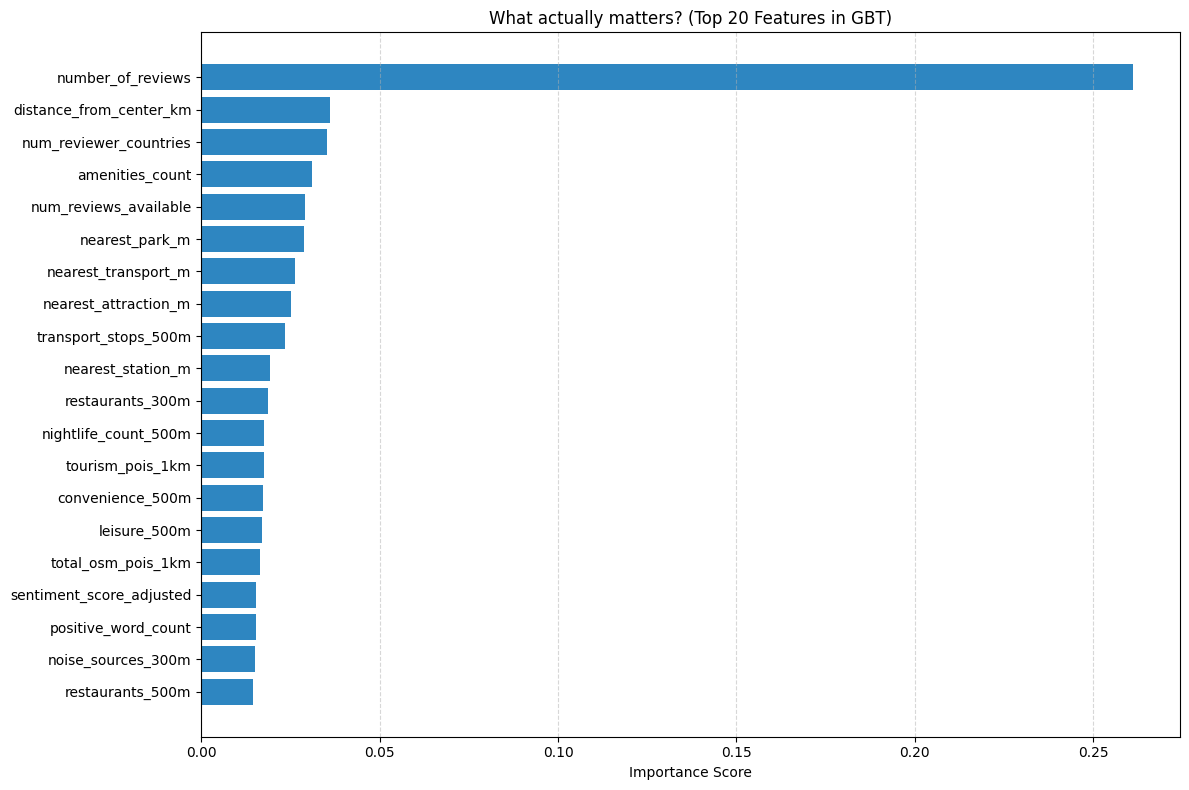

In [0]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

#Get feature importance from the GBT model
feature_importance = gbt_model.featureImportances.toArray()

#Create importance dataframe
importance_df = spark.createDataFrame(
    [(feat, float(imp)) for feat, imp in zip(existing_features, feature_importance)],
    ["feature", "importance"]
).orderBy(F.desc("importance"))

#Show top 30 most important features
print("=" * 60)
print("TOP 30 DRIVERS OF HOTEL SCORES (GBT MODEL)")
print("=" * 60)
display(importance_df.limit(30))

#Save feature importance for plotting
importance_pdf = importance_df.toPandas()

#Visualize top 20 features
top_20 = importance_pdf.head(20)

plt.figure(figsize=(12, 8))
#Added a color and grid for better readability
plt.barh(range(len(top_20)), top_20['importance'].values, align='center', color='#2E86C1')
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Importance Score')
plt.title('What actually matters? (Top 20 Features in GBT)')
plt.gca().invert_yaxis()  # Put the most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [0]:
# Categorize features
def categorize_feature(feat):
    if feat in EXPECTATION_FEATURES:
        return "Expectation"
    elif feat in SPATIAL_FEATURES_OSM:
        return "Spatial (OSM)"
    elif feat in SPATIAL_FEATURES_GMAPS:
        return "Spatial (GMaps)"
    elif feat in NLP_FEATURES:
        return "NLP/Reviews"
    else:
        return "Other"

importance_pdf['category'] = importance_pdf['feature'].apply(categorize_feature)

# Aggregate importance by category
category_importance = importance_pdf.groupby('category')['importance'].sum().sort_values(ascending=False)

print("=" * 50)
print("FEATURE IMPORTANCE BY CATEGORY")
print("=" * 50)
print(category_importance)
print("-" * 50)
print(f"Total: {category_importance.sum():.3f}")

FEATURE IMPORTANCE BY CATEGORY
category
Other              0.356842
Spatial (OSM)      0.306473
Expectation        0.174172
NLP/Reviews        0.085643
Spatial (GMaps)    0.076869
Name: importance, dtype: float64
--------------------------------------------------
Total: 1.000


# Gap Score

In [0]:
from pyspark.sql.functions import col, lit, when
import pyspark.sql.functions as F

final_model = gbt_model 

# PREDICT REALITY
# We apply the GBT model to ALL hotels 
all_predictions = final_model.transform(hotel_assembled)

# CALCULATE GAP & CREATE FINAL DATAFRAME
all_predictions = all_predictions.withColumn(
    "predicted_reality_score",
    col("prediction")
).withColumn(
    # Gap = Listed Score - Reality Score
    # Positive Gap = Overrated (Listed is higher than Reality)
    "gap_score_raw",
    col(TARGET) - col("prediction")
).withColumn(
    # Normalize to 0-100 scale for easier plotting (50 is a perfect match)
    "gap_score",
    F.greatest(
        lit(0.0),
        F.least(
            lit(100.0),
            (col("gap_score_raw") + 5) * 10
        )
    )
).withColumn(
    # Categorize the Gap for the App/Report
    "gap_category",
    when(col("gap_score_raw") > 1.5, "High Risk - Likely to Disappoint")
    .when(col("gap_score_raw") > 0.5, "Medium Risk")
    .when(col("gap_score_raw") > -0.5, "As Expected")
    .when(col("gap_score_raw") > -1.5, "Better Than Expected")
    .otherwise("Much Better Than Expected - Hidden Gem")
)

#INSPECT THE FINAL RESULTS
print("=== GBT Final Analysis Results ===")
print(f"Total Hotels Scored: {all_predictions.count():,}")
display(
    all_predictions.select(
        "hotel_id", 
        "title", 
        col("review_score").alias("listed_score"), 
        F.round("predicted_reality_score", 1).alias("reality_score"), 
        F.round("gap_score_raw", 2).alias("gap"),
        "gap_category"
    ).orderBy(col("gap_score_raw").desc()).limit(10)
)

=== GBT Final Analysis Results ===
Total Hotels Scored: 22,988


hotel_id,title,listed_score,reality_score,gap,gap_category
13298122,Maya's Palace דירת הנופש של מאיה,9.0,0.9,8.06,High Risk - Likely to Disappoint
1587932,Monnalisa Home,9.0,1.1,7.87,High Risk - Likely to Disappoint
13291764,Cosy Home for 6 by Brixton Station,9.0,1.5,7.55,High Risk - Likely to Disappoint
11666318,"Gorgeous flat prime location, London (updated prices 2025)",8.0,0.5,7.51,High Risk - Likely to Disappoint
11288374,Seaside Retreat-3BR Bliss in JBR,9.0,1.8,7.22,High Risk - Likely to Disappoint
10237936,Hantke28 Budget Apartment,9.5,2.3,7.17,High Risk - Likely to Disappoint
11421239,GuestReady - Calm Garden Home in Downtown’s Heart,9.0,1.9,7.08,High Risk - Likely to Disappoint
12067201,BTS onnut one bedroom free WiFi quiet room,7.1,0.6,6.49,High Risk - Likely to Disappoint
12942256,Graceful 2-Bedroom in Downtown Dubai with Burj Khalifa View!,8.0,1.5,6.46,High Risk - Likely to Disappoint
10410285,T-house Bkk - Max15 people with private swimming pool,9.5,3.1,6.43,High Risk - Likely to Disappoint


## Gap score by City

In [0]:
# Gap scores by city
print("=== Gap Scores by City ===")
display(
    all_predictions
    .groupBy("city")
    .agg(
        F.count("*").alias("hotels"),
        F.round(F.avg(TARGET), 2).alias("avg_listed_score"),
        F.round(F.avg("predicted_reality_score"), 2).alias("avg_predicted"),
        F.round(F.avg("gap_score_raw"), 3).alias("avg_gap_raw"),
        F.round(F.avg("gap_score"), 1).alias("avg_gap_score"),
        F.sum(when(col("gap_score_raw") > 1, 1).otherwise(0)).alias("high_risk_count")
    )
    .orderBy(F.desc("avg_gap_raw"))
)

=== Gap Scores by City ===


city,hotels,avg_listed_score,avg_predicted,avg_gap_raw,avg_gap_score,high_risk_count
Haifa,42,8.31,8.02,0.283,52.3,3
Tel Aviv,100,7.62,7.55,0.066,50.7,4
Eilat,80,8.59,8.55,0.038,50.3,3
New York,665,5.08,5.06,0.022,50.3,28
Bangkok,1806,7.6,7.58,0.017,50.2,53
Amsterdam,489,8.21,8.2,0.01,50.1,8
Tokyo,3686,7.42,7.41,0.009,50.1,175
Rome,7621,8.53,8.53,0.002,50.0,114
Dubai,1384,7.06,7.07,-0.004,50.0,98
London,7115,7.4,7.41,-0.01,49.9,348


### High-gap hotels

In [0]:
# Hotels most likely to disappoint
print("=== TOP 20 HIGHEST RISK HOTELS (Most Likely to Disappoint) ===")
display(
    all_predictions
    .filter(col("gap_score_raw") > 0)  # Positive gap = disappointing
    .select(
        "hotel_id", "city", "title",
        F.round(col(TARGET), 1).alias("listed_score"),
        F.round(col("predicted_reality_score"), 1).alias("predicted_score"),
        F.round(col("gap_score_raw"), 2).alias("gap"),
        F.round(col("gap_score"), 0).alias("gap_score_100"),
        "gap_category"
    )
    .orderBy(F.desc("gap_score_raw"))
    .limit(20)
)

# Hotels that exceed expectations
print("=== TOP 20 HOTELS EXCEEDING EXPECTATIONS ===")
display(
    all_predictions
    .filter(col("gap_score_raw") < -0.5)  # Negative gap = better than expected
    .select(
        "hotel_id", "city", "title",
        F.round(col(TARGET), 1).alias("listed_score"),
        F.round(col("predicted_reality_score"), 1).alias("predicted_score"),
        F.round(col("gap_score_raw"), 2).alias("gap"),
        "gap_category"
    )
    .orderBy("gap_score_raw")
    .limit(20)
)

=== TOP 20 HIGHEST RISK HOTELS (Most Likely to Disappoint) ===


hotel_id,city,title,listed_score,predicted_score,gap,gap_score_100,gap_category
13298122,Eilat,Maya's Palace דירת הנופש של מאיה,9.0,0.9,8.06,100.0,High Risk - Likely to Disappoint
1587932,Rome,Monnalisa Home,9.0,1.1,7.87,100.0,High Risk - Likely to Disappoint
13291764,London,Cosy Home for 6 by Brixton Station,9.0,1.5,7.55,100.0,High Risk - Likely to Disappoint
11666318,London,"Gorgeous flat prime location, London (updated prices 2025)",8.0,0.5,7.51,100.0,High Risk - Likely to Disappoint
11288374,Dubai,Seaside Retreat-3BR Bliss in JBR,9.0,1.8,7.22,100.0,High Risk - Likely to Disappoint
10237936,Haifa,Hantke28 Budget Apartment,9.5,2.3,7.17,100.0,High Risk - Likely to Disappoint
11421239,Dubai,GuestReady - Calm Garden Home in Downtown’s Heart,9.0,1.9,7.08,100.0,High Risk - Likely to Disappoint
12067201,Bangkok,BTS onnut one bedroom free WiFi quiet room,7.1,0.6,6.49,100.0,High Risk - Likely to Disappoint
12942256,Dubai,Graceful 2-Bedroom in Downtown Dubai with Burj Khalifa View!,8.0,1.5,6.46,100.0,High Risk - Likely to Disappoint
10410285,Bangkok,T-house Bkk - Max15 people with private swimming pool,9.5,3.1,6.43,100.0,High Risk - Likely to Disappoint


=== TOP 20 HOTELS EXCEEDING EXPECTATIONS ===


hotel_id,city,title,listed_score,predicted_score,gap,gap_category
12942066,London,Chic and Cozy 3-Bed Flat near Kings Cross,1.0,10.3,-9.26,Much Better Than Expected - Hidden Gem
11096029,London,Marylebone central apartment,1.0,9.3,-8.25,Much Better Than Expected - Hidden Gem
12644889,Dubai,WelHome - Luxury Apt in Downtown with Burj Khalifa & Fountain View #Cloud11,1.0,9.1,-8.13,Much Better Than Expected - Hidden Gem
12193143,Dubai,Frank Porter - 1 Residences 1,1.0,9.0,-8.01,Much Better Than Expected - Hidden Gem
13348553,London,"Modern 2-Bed, 2-Bath, Clapham Junction, Parking Spot Included",1.0,8.9,-7.95,Much Better Than Expected - Hidden Gem
12615995,London,Amazing 3BR near Brick Lane,1.6,9.4,-7.83,Much Better Than Expected - Hidden Gem
13111581,New York,Urban Luxury Hudson River Suite,1.0,8.8,-7.77,Much Better Than Expected - Hidden Gem
12223434,Tokyo,"39, Kanegafuchi 2, Entire house for rent",1.0,8.6,-7.62,Much Better Than Expected - Hidden Gem
11824223,Eilat,דירת משפחתית 2 חדרי שינה במיקום מרכזי - By Edom,1.0,8.4,-7.4,Much Better Than Expected - Hidden Gem
11617386,Dubai,"Breathtaking views from Vida Dubai Marina, Dubai (updated prices 2025)",1.0,8.4,-7.39,Much Better Than Expected - Hidden Gem


# Creating tables for web-app

In [0]:


from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, round as spark_round, concat_ws, lit

hotel_webapp = all_predictions.select(

    "hotel_id",
    "city",
    "title",
    "url",
    "lat",
    "lon",
    
    spark_round(col("review_score"), 1).alias("review_score"),
    spark_round(col("predicted_reality_score"), 1).alias("predicted_reality_score"),
    spark_round(col("gap_score"), 0).alias("gap_score"),
    col("gap_category"),
    "number_of_reviews",
    spark_round(col("manager_score"), 1).alias("manager_score"),

    col("total_complaints"),
    col("total_praises"),
    
    # Complaint flags 
    col("complaint_noise").cast("int").alias("complaint_noise"),
    col("complaint_cleanliness").cast("int").alias("complaint_cleanliness"),
    col("complaint_location").cast("int").alias("complaint_location"),
    col("complaint_amenities").cast("int").alias("complaint_amenities"),
    col("complaint_host").cast("int").alias("complaint_host"),
    col("complaint_value").cast("int").alias("complaint_value"),
    
    # Praise flags
    col("praise_quiet").cast("int").alias("praise_quiet"),
    col("praise_clean").cast("int").alias("praise_clean"),
    col("praise_location").cast("int").alias("praise_location"),
    col("praise_amenities").cast("int").alias("praise_amenities"),
    col("praise_host").cast("int").alias("praise_host"),
    col("praise_value").cast("int").alias("praise_value"),
    
    # AMENITIES
    col("has_wifi").cast("int").alias("has_wifi"),
    col("has_parking").cast("int").alias("has_parking"),
    col("has_ac").cast("int").alias("has_ac"),
    col("has_pool").cast("int").alias("has_pool"),
    col("has_gym").cast("int").alias("has_gym"),
    col("has_kitchen").cast("int").alias("has_kitchen"),
    col("has_breakfast").cast("int").alias("has_breakfast"),
    col("has_spa").cast("int").alias("has_spa"),
    col("has_elevator").cast("int").alias("has_elevator"),
    col("has_balcony").cast("int").alias("has_balcony"),
    col("has_restaurant").cast("int").alias("has_restaurant"),
    col("has_pet_friendly").cast("int").alias("has_pet_friendly"),
    "amenities_count",
    
    # LOCATION
    spark_round(col("distance_from_center_km"), 2).alias("distance_from_center_km"),
    "noise_sources_500m",
    "nightlife_count_500m",
    "restaurants_500m",
    "parks_500m",
    spark_round(col("nearest_transport_m"), 0).alias("nearest_transport_m"),
    col("metro_railway_access").cast("int").alias("metro_railway_access"),
    
    #  NEIGHBORHOOD 
    spark_round(col("avg_restaurant_rating_500m"), 1).alias("avg_restaurant_rating_500m"),
    "high_rated_restaurants_500m",
    
    
    "all_reviews_text",
    "description"
)

# Add display-friendly columns
hotel_webapp = hotel_webapp.withColumn(
    # Risk level for color coding (1=green, 2=yellow, 3=orange, 4=red)
    "risk_level",
    when(col("gap_category") == "High Risk - Likely to Disappoint", 4)
    .when(col("gap_category") == "Medium Risk", 3)
    .when(col("gap_category") == "As Expected", 2)
    .otherwise(1)
).withColumn(
    # Trust badge for quick visual
    "trust_badge",
    when(col("gap_category") == "Much Better Than Expected", "Hidden Gem")
    .when(col("gap_category") == "Better Than Expected", "Exceeds Expectations")
    .when(col("gap_category") == "As Expected", "Reliable")
    .when(col("gap_category") == "Medium Risk", "Some Concerns")
    .otherwise("Overhyped")
).withColumn(
    # Complaint summary text
    "main_complaints",
    concat_ws(", ",
        when(col("complaint_noise") == 1, lit("Noise")).otherwise(lit(None)),
        when(col("complaint_cleanliness") == 1, lit("Cleanliness")).otherwise(lit(None)),
        when(col("complaint_location") == 1, lit("Location")).otherwise(lit(None)),
        when(col("complaint_amenities") == 1, lit("Amenities")).otherwise(lit(None)),
        when(col("complaint_host") == 1, lit("Host")).otherwise(lit(None)),
        when(col("complaint_value") == 1, lit("Value")).otherwise(lit(None))
    )
).withColumn(
    # Praise summary text
    "main_praises",
    concat_ws(", ",
        when(col("praise_quiet") == 1, lit("Quiet")).otherwise(lit(None)),
        when(col("praise_clean") == 1, lit("Clean")).otherwise(lit(None)),
        when(col("praise_location") == 1, lit("Location")).otherwise(lit(None)),
        when(col("praise_amenities") == 1, lit("Amenities")).otherwise(lit(None)),
        when(col("praise_host") == 1, lit("Host")).otherwise(lit(None)),
        when(col("praise_value") == 1, lit("Value")).otherwise(lit(None))
    )
)

# Filter out hotels without coordinates
hotel_webapp = hotel_webapp.filter(
    col("lat").isNotNull() & col("lon").isNotNull()
)

print(f"Hotels ready for web app: {hotel_webapp.count():,}")
print(f"Total columns: {len(hotel_webapp.columns)}")

# Show sample
print("\n=== Sample Data ===")
display(
    hotel_webapp
    .select(
        "title", "city", "review_score", "predicted_reality_score",
        "gap_score", "trust_badge", "main_complaints", "main_praises"
    )
    .limit(10)
)

Hotels ready for web app: 22,988
Total columns: 54

=== Sample Data ===


title,city,review_score,predicted_reality_score,gap_score,trust_badge,main_complaints,main_praises
"Casa Vacanza da Emy, Rome (updated prices 2025)",Rome,9.6,9.1,55.0,Some Concerns,Location,"Quiet, Clean, Location, Amenities, Host"
Suite La chiostrina al Cedro,Rome,9.6,8.7,59.0,Some Concerns,Cleanliness,"Quiet, Clean, Location"
A.D. Navona Apartment,Rome,8.4,7.9,55.0,Some Concerns,"Noise, Cleanliness","Quiet, Clean, Amenities, Host, Value"
Terrace Jewel by Campo de Fiori,Rome,8.6,8.4,52.0,Reliable,Noise,"Clean, Location"
BDC - The Secret Garden in Trevi,Rome,7.4,9.2,32.0,Overhyped,,"Quiet, Location"
Residenza Talenti Superior Rooms,Rome,9.1,8.7,54.0,Reliable,"Location, Amenities","Quiet, Host"
Bragadin75 In Vaticano,Rome,9.7,9.4,53.0,Reliable,"Noise, Cleanliness","Clean, Amenities, Host"
Fabrizio's Rooms,Rome,8.2,8.5,47.0,Reliable,"Noise, Cleanliness","Location, Amenities, Host"
Appartamento 5 stelle in Piazza Asti - Re di Roma -,Rome,8.3,8.3,50.0,Reliable,,Quiet
"Frank Host Roma Lux , Metro A a 50 m, simple check-in con codice a qualsiasi orario",Rome,9.7,9.4,53.0,Reliable,Cleanliness,"Quiet, Clean, Location, Amenities"


In [0]:
hotel_webapp.write.mode("overwrite").parquet("dbfs:/FileStore/project/gold/hotel_webapp")

print(f"Saved {hotel_webapp.count():,} hotels")

# Show final schema
print("\n=== FINAL COLUMNS ===")
for c in hotel_webapp.columns:
    print(f"  {c}")

Saved 22,988 hotels

=== FINAL COLUMNS ===
  hotel_id
  city
  title
  url
  lat
  lon
  review_score
  predicted_reality_score
  gap_score
  gap_category
  number_of_reviews
  manager_score
  total_complaints
  total_praises
  complaint_noise
  complaint_cleanliness
  complaint_location
  complaint_amenities
  complaint_host
  complaint_value
  praise_quiet
  praise_clean
  praise_location
  praise_amenities
  praise_host
  praise_value
  has_wifi
  has_parking
  has_ac
  has_pool
  has_gym
  has_kitchen
  has_breakfast
  has_spa
  has_elevator
  has_balcony
  has_restaurant
  has_pet_friendly
  amenities_count
  distance_from_center_km
  noise_sources_500m
  nightlife_count_500m
  restaurants_500m
  parks_500m
  nearest_transport_m
  metro_railway_access
  avg_restaurant_rating_500m
  high_rated_restaurants_500m
  all_reviews_text
  description
  risk_level
  trust_badge
  main_complaints
  main_praises


In [0]:
# Save to FileStore 
output_path = "/FileStore/tables/hotel_webapp.csv"

hotel_webapp.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(f"dbfs:{output_path}")

# Get the actual filename
files = dbutils.fs.ls(f"dbfs:{output_path}")
csv_file = [f.name for f in files if f.name.startswith("part-")][0]

# Create download URL
workspace_url = spark.conf.get("spark.databricks.workspaceUrl")
download_url = f"https://{workspace_url}/files/tables/hotel_webapp.csv/{csv_file}"

print("="*60)
print("DOWNLOAD YOUR CSV HERE:")
print(download_url)
print("="*60)

DOWNLOAD YOUR CSV HERE:
https://adb-983293358114278.18.azuredatabricks.net/files/tables/hotel_webapp.csv/part-00000-tid-9113571959853539405-2495492c-31ba-4cb4-a792-aa3d477a11cd-21963-1-c000.csv


#Viz

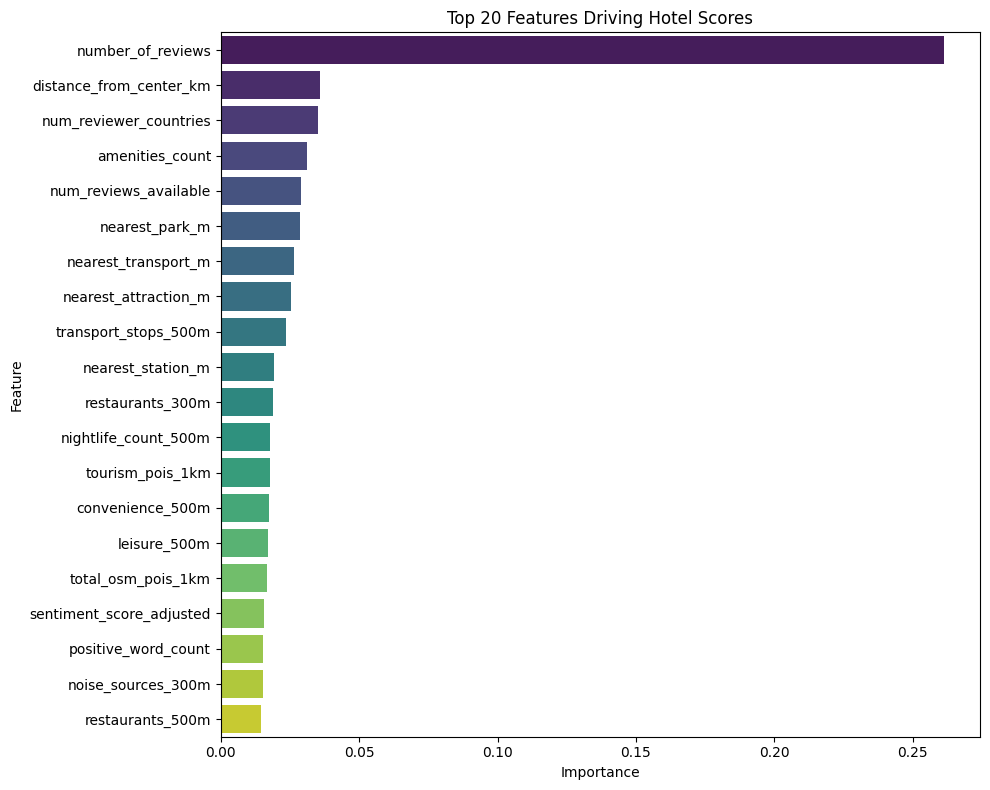

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert your existing importance dataframe to pandas
feat_imp_pd = importance_df.limit(20).toPandas()
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=feat_imp_pd, palette="viridis")
plt.title("Top 20 Features Driving Hotel Scores")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

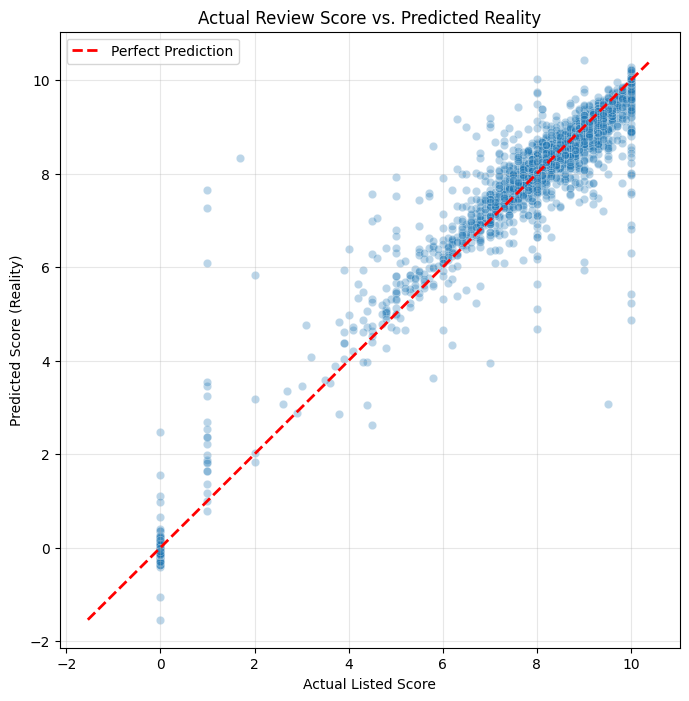

In [0]:
# Sample 2000 points to avoid overplotting 
sample_preds = all_predictions.select(TARGET, "prediction").sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=sample_preds[TARGET], y=sample_preds["prediction"], alpha=0.3)
min_val = min(sample_preds[TARGET].min(), sample_preds["prediction"].min())
max_val = max(sample_preds[TARGET].max(), sample_preds["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Perfect Prediction")

plt.title("Actual Review Score vs. Predicted Reality")
plt.xlabel("Actual Listed Score")
plt.ylabel("Predicted Score (Reality)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

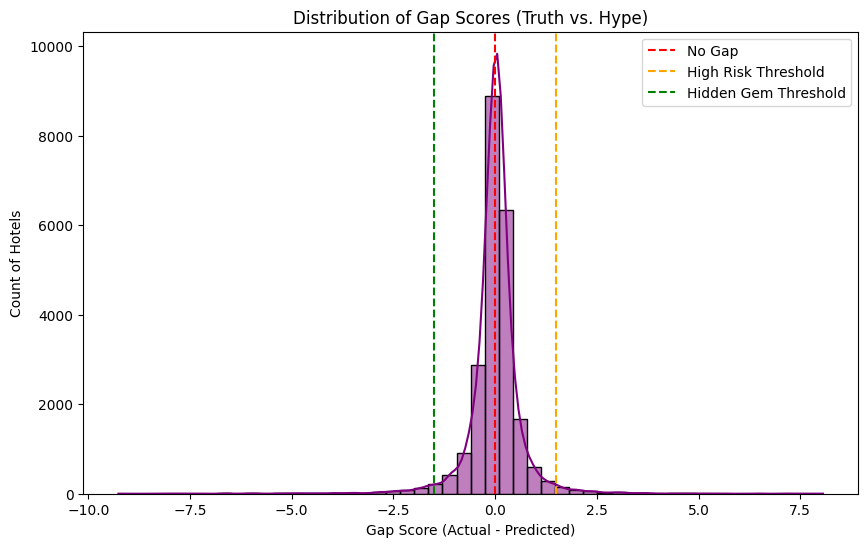

In [0]:
# Convert gap scores to pandas for plotting
gap_data = all_predictions.select("gap_score_raw").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(gap_data["gap_score_raw"], bins=50, kde=True, color="purple")
plt.axvline(x=0, color='red', linestyle='--', label="No Gap")
plt.axvline(x=1.5, color='orange', linestyle='--', label="High Risk Threshold")
plt.axvline(x=-1.5, color='green', linestyle='--', label="Hidden Gem Threshold")

plt.title("Distribution of Gap Scores (Truth vs. Hype)")
plt.xlabel("Gap Score (Actual - Predicted)")
plt.ylabel("Count of Hotels")
plt.legend()
plt.show()

# Aggregate data for boxplot
city_gaps = all_predictions.select("city", "gap_score_raw").toPandas()




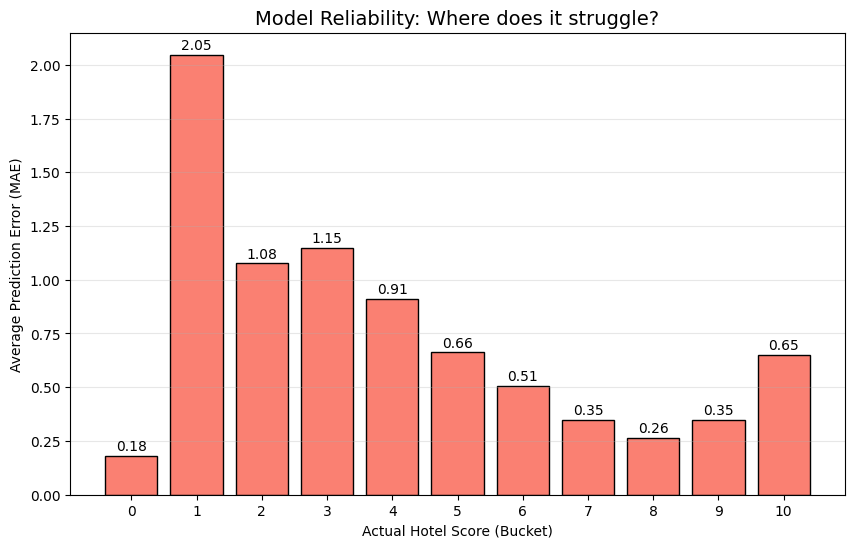

In [0]:
from pyspark.sql.functions import col, floor

# Create Score Buckets (e.g., 6.0, 7.0, 8.0...)
bucketed_error = all_predictions.withColumn(
    "score_bucket", 
    floor(col(TARGET)) # Buckets: 6, 7, 8, 9...
).withColumn(
    "abs_error", 
    F.abs(col(TARGET) - col("prediction"))
)

# Calculate Mean Absolute Error (MAE) per bucket
error_by_bucket = bucketed_error.groupBy("score_bucket") \
    .agg(F.mean("abs_error").alias("mae"), F.count("*").alias("count")) \
    .orderBy("score_bucket") \
    .toPandas()

# Filter out buckets with very few hotels to avoid noise
error_by_bucket = error_by_bucket[error_by_bucket['count'] > 50]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(error_by_bucket["score_bucket"], error_by_bucket["mae"], color='salmon', edgecolor='black')

plt.title("Model Reliability: Where does it struggle?", fontsize=14)
plt.xlabel("Actual Hotel Score (Bucket)")
plt.ylabel("Average Prediction Error (MAE)")
plt.xticks(error_by_bucket["score_bucket"])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()

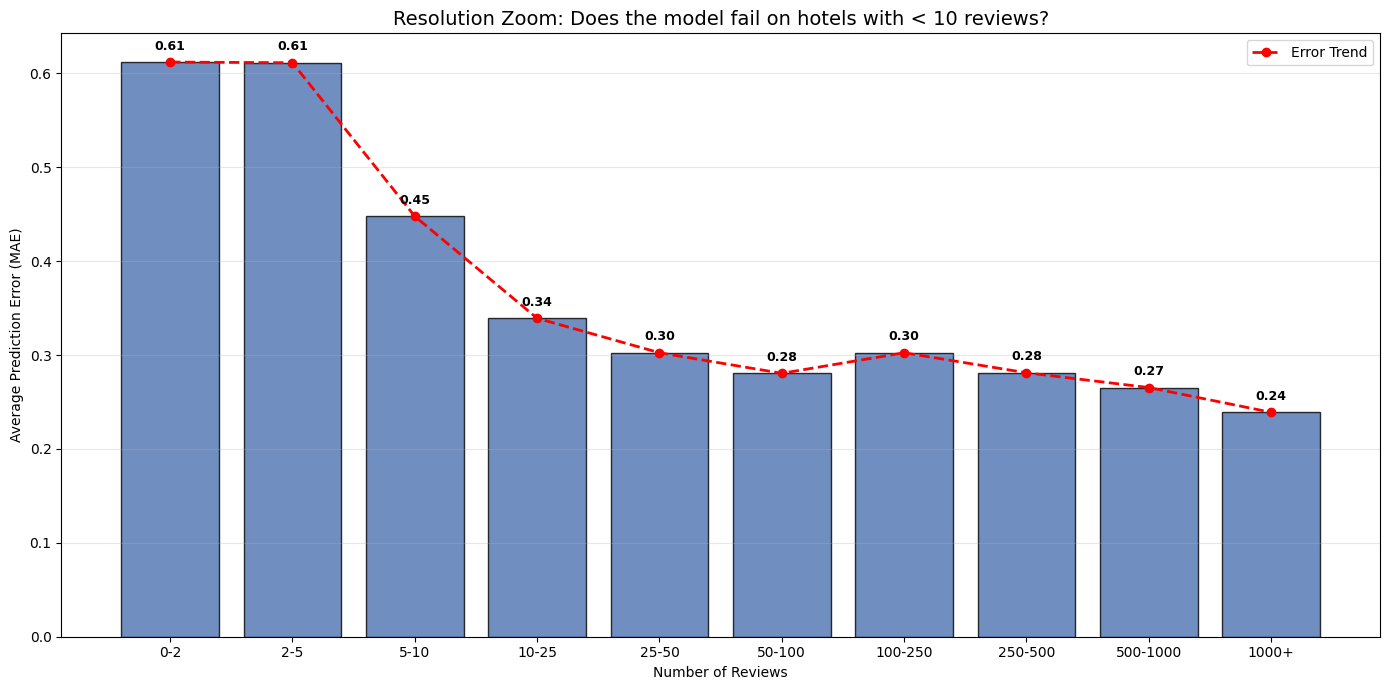

In [0]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import abs, col, mean, count
import matplotlib.pyplot as plt
import pandas as pd

# Define High-Resolution Buckets
splits = [0, 2, 5, 10, 25, 50, 100, 250, 500, 1000, float('inf')]
labels = ["0-2", "2-5", "5-10", "10-25", "25-50", "50-100", "100-250", "250-500", "500-1000", "1000+"]

# Bucket the Data
bucketizer = Bucketizer(splits=splits, inputCol="number_of_reviews", outputCol="reviews_bucket_id")
bucketed_data = bucketizer.transform(all_predictions)

# Calculate Error per Bucket
error_by_popularity = bucketed_data.withColumn("abs_error", abs(col(TARGET) - col("prediction"))) \
    .groupBy("reviews_bucket_id") \
    .agg(mean("abs_error").alias("mae"), count("*").alias("count")) \
    .orderBy("reviews_bucket_id") \
    .toPandas()

# Map IDs back to Labels
error_by_popularity["label"] = error_by_popularity["reviews_bucket_id"].apply(
    lambda x: labels[int(x)] if int(x) < len(labels) else "Unknown"
)


plt.figure(figsize=(14, 7)) # Made wider to fit the extra labels

# Create the bar chart
bars = plt.bar(error_by_popularity["label"], error_by_popularity["mae"], color='#4c72b0', edgecolor='black', alpha=0.8)

# Add Trend Line
plt.plot(error_by_popularity["label"], error_by_popularity["mae"], color='red', marker='o', linestyle='--', linewidth=2, label="Error Trend")

# Formatting
plt.title("Resolution Zoom: Does the model fail on hotels with < 10 reviews?", fontsize=14)
plt.xlabel("Number of Reviews")
plt.ylabel("Average Prediction Error (MAE)")
plt.grid(axis='y', alpha=0.3)
plt.legend()

# Add values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()